In [112]:
%matplotlib inline
%tensorflow_version 1.10

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.10`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [113]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras%
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

from tensorflow.keras import optimizers


from sklearn.metrics import confusion_matrix
import itertools

# CIFAR-10

## Ładowanie zbioru danych

In [114]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

y_train = y_train.reshape((1,-1))[0]
y_test = y_test.reshape((1,-1))[0]

print("Training matrix shape", X_train.shape, y_train.shape)
print("Testing matrix shape", X_test.shape, y_test.shape)

# one-hot format classes

nb_classes = 10 

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

cifar_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Training matrix shape (50000, 32, 32, 3) (50000,)
Testing matrix shape (10000, 32, 32, 3) (10000,)


## Podgląd zbioru treningowego

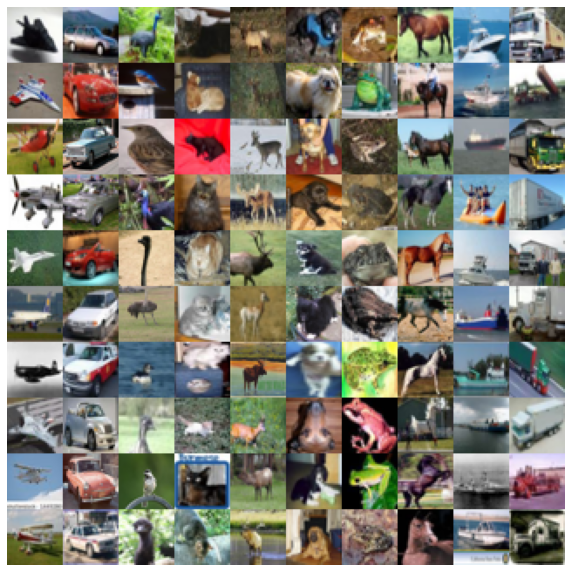

In [115]:
for i in range(0, 10):
  img_batch = X_train[y_train == i][0:10]
  img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2], img_batch.shape[3]))
  if i > 0:
    img = np.concatenate([img, img_batch], axis = 1)
  else:
    img = img_batch
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(img, cmap='gray')


## Przygotowanie modelu

In [116]:
def generate_model():
  model = Sequential()                                 # Linear stacking of layers

  # Convolution Layer 1
  model.add(Conv2D(16, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu') )  

  # ...

  model.add(Flatten())                                 # Flatten final output matrix into a vector

  # ...

  # Fully Connected Layer                        
  model.add(Dense(10))                                 # final 10 FC nodes
  model.add(Activation('softmax'))                     # softmax activation

  model.summary()
  
  adam = optimizers.Adam(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model

In [117]:
model = generate_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 activation_14 (Activation)  (None, 30, 30, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         
                                                                 
 dense_13 (Dense)            (None, 10)                144010    
                                                                 
 activation_15 (Activation)  (None, 10)                0         
                                                                 
Total params: 144,458
Trainable params: 144,458
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Trening

In [118]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08, validation_split=0.2)

train_generator = gen.flow(X_train, Y_train, batch_size=128, subset='training')
valid_generator = gen.flow(X_train, Y_train, batch_size=128, subset='validation')

In [119]:
model.fit_generator(train_generator, steps_per_epoch=50000//128, epochs=2, verbose=1, validation_data=valid_generator, validation_steps = 10000 // 128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/2
390/390 [==============================] - 38s 97ms/step - loss: 1.6813 - accuracy: 0.4059 - val_loss: 1.4754 - val_accuracy: 0.4788


## Test

313/313 [==============================] - 2s 5ms/step - loss: 1.4299 - accuracy: 0.4953
Test score: 1.4299001693725586
Test accuracy: 0.4952999949455261
Confusion matrix, without normalization
[[522  79  38  27  24  15  29  55 121  90]
 [ 25 694   2  12   8  11  30  42  30 146]
 [ 66  34 163  91 199  92 174 131  26  24]
 [ 20  23  36 316  62 191 177 119   6  50]
 [ 27  14  32  72 364  81 170 204  13  23]
 [ 16  12  30 177  74 404  97 160  15  15]
 [  5  18  16  68  83  39 671  68   4  28]
 [  9  18  10  71  33  70  52 682   5  50]
 [128 125  14  21   7  18  25  27 540  95]
 [ 25 200   2  24   8  14  44  66  20 597]]


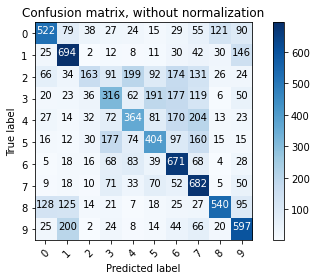

In [120]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
#predicted_classes = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
predicted_classes=np.argmax(predict_x,axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


cnf_matrix = confusion_matrix(y_test, predicted_classes)

class_names = [str(i) for i in range(10)]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [121]:
def show_samples_rgb(indices, preds, images, labels, count=3, names = []):
    plt.figure()
    for i, sample in enumerate(indices[:count**2]):
        plt.subplot(count,count,i+1)
        plt.imshow(images[sample], interpolation='none')
        plt.axis('off')
        if len(names) > 0:
          plt.title("Predicted {}\nClass {}".format(names[int(preds[sample])], names[int(labels[sample])]))
        else:
          plt.title("Predicted {}\nClass {}".format(preds[sample], labels[sample]))          
    
    plt.tight_layout()

## Poprawne klasyfikacje

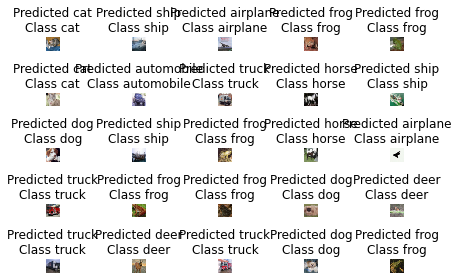

In [122]:
show_samples_rgb(correct_indices, predicted_classes, X_test, y_test, 5, cifar_names)

## Błędne klasyfikacje

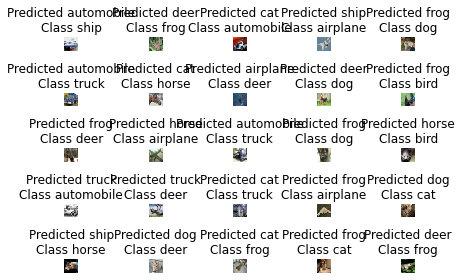

In [123]:
show_samples_rgb(incorrect_indices, predicted_classes, X_test, y_test, 5, cifar_names)